# Train Word2Vec with gensim & application of embeddings in document similarity

## Install required packages

In [ ]:
# scipy issue with gensim
# https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-gensim

!pip install scipy==1.10.1 numpy gensim scikit-learn matplotlib spacy lxml
!python -m spacy download en_core_web_sm

## Import required packages

In [1]:
# Import necessary libraries
import re
import string
import glob

import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm

# Load the English language model
nlp = spacy.load("en_core_web_sm")

## Define Tokenizer

In [1]:
def tokenize(text) -> list:
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. 
      1. Normalize to lowercase. Strip punctuation, numbers, and `\r`, `\n`\, `\t`.
      2. Replace multiple spaces for a single space.
      3. Tokenize with spacy.
      4. Remove stopwords with spacy.
      5. Remove tokens with len <= 2
      6. Apply lemmatization to words using spacy.
    """
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n\\*]', ' ', text)
    # your code here
    text = re.sub(' +', ' ', text)
    tokens = [token.lemma_ for token in nlp(text) if len(token) > 2 and not token.is_stop]
    return tokens

## Load job description dataset

In [3]:
# Path to the job descriptions
all_files = glob.glob("data/*.csv")

# Load job description data
df = []

# Loop through each CSV file, read it into a DataFrame, and append it to the list
for filename in all_files:
    _df = pd.read_csv(filename)
    df.append(_df)

df = pd.concat(df, ignore_index=True)
valid_descriptions = df[~df['description'].isna()]['description']

## Split dataset into training / test

## Train the word2vec model

In [6]:
# Tokenize job descriptions by spacy
tokenized_descriptions = []
for description in tqdm(valid_descriptions):
    tokens = tokenize(description, nlp)
    tokenized_descriptions.append(tokens)

100%|██████████| 600/600 [00:28<00:00, 21.11it/s]


In [7]:
# Train Word2Vec model
model = Word2Vec(tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=12)
trained_word_count, raw_word_count = model.train(tokenized_descriptions, total_examples=len(tokenized_descriptions), epochs=10)

## Plot tsne representation of word embeddings around the target word "Python"

In [8]:
# Visualize word embeddings using t-SNE
def tsne_plot(model, target_word, k=100):
    labels = []
    wordvecs = []

    similarity_to_target_word = []
    for word in tqdm(model.wv.key_to_index):
        similarity = model.wv.similarity(word, target_word)
        similarity_to_target_word.append((word, similarity))
    top_similar_words = [pair[0] for pair in sorted(similarity_to_target_word, key=lambda x: x[1], reverse=True)[:k]]

    for word in top_similar_words:
        if word in model.wv.key_to_index:
            wordvecs.append(model.wv[word])
            labels.append(word)

    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(wordvecs))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        if labels[i] == target_word:
            plt.scatter(x[i], y[i], s=500)
        else:
            plt.scatter(x[i], y[i], s=30)
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.title(f"top-{k} similar embeddings of words with that of target word ({target_word})")
    plt.show()

100%|██████████| 7471/7471 [00:00<00:00, 99823.98it/s]
c:\Users\inseong\miniconda3\envs\word2vec\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\inseong\miniconda3\envs\word2vec\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\inseong\miniconda3\envs\word2vec\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\inseong\miniconda3\envs\word2vec\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\inseong\miniconda3\envs\word2vec\lib\subprocess.py", line 1456, in _execute

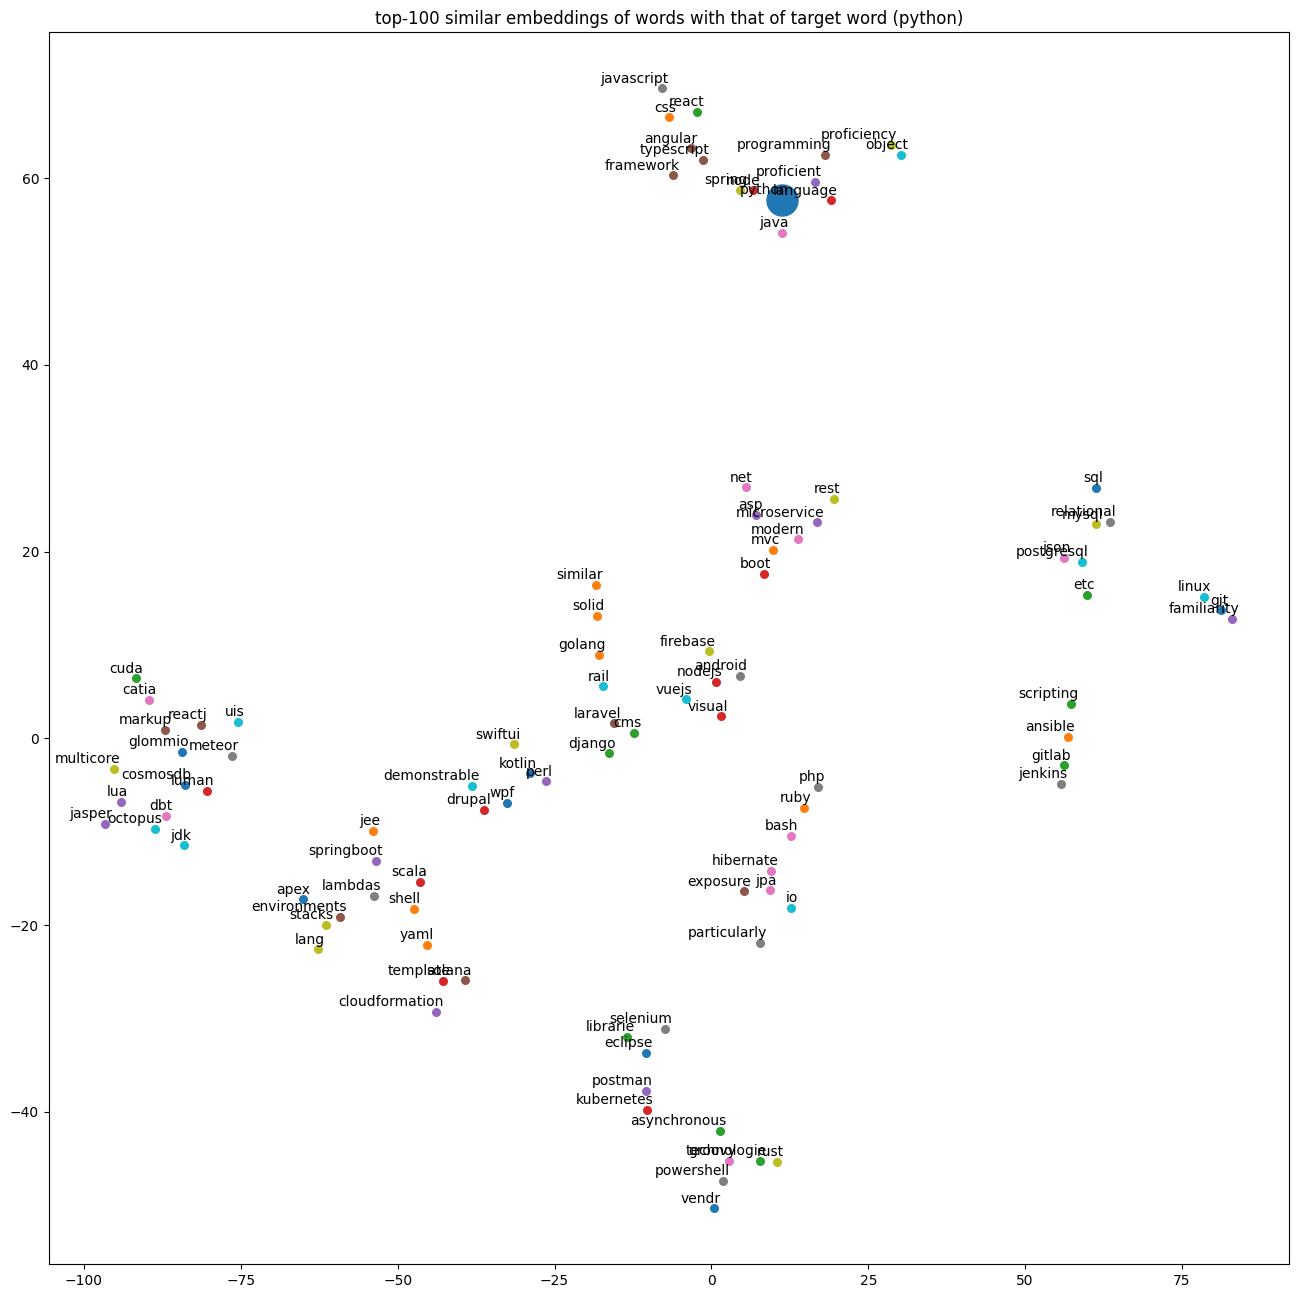

In [9]:
k = 100
target_word = "python"
tsne_plot(model, target_word, k)

## Document similarity

In [10]:
doc_embeddings = []
for tokens_in_doc in tokenized_descriptions:
    embedding = model.wv[tokens_in_doc[0]].copy()
    for token in tokens_in_doc[1:]:
        embedding += model.wv[token]
    embedding /= len(tokens_in_doc)
    doc_embeddings.append(embedding.reshape(1, -1))

In [11]:
index = 0
print(valid_descriptions[index])

**Job Description:**  
We are seeking a Hyperion Developer to join a team providing configuration and capability support services for project at the Pentagon in Washington, DC.

In this role you will be responsible for the overall design and deployment of the ERP application system architecture. An expert in various ERP related technologies and system architecture components and can serve as the overall technical lead of the program.

Specific tasks you will perform as a Hyperion Developer include, but are not limited to:

* Participate in the design, development, and implementation of new system functionality
* Will provide guidance on the best technologies for the project
* Provide technical support and troubleshooting to resolve system issues, ensuring optimal system performance and stability
* Analyzes requirements, procedures, and problems to automate processing and/or testing to help improve existing systems
* Drive continuous improvement initiatives to optimize system performanc

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
target_embedding = doc_embeddings[index]
similarity = [cosine_similarity(target_embedding, doc_embedding).squeeze() for doc_embedding in doc_embeddings]

k = 5
top_k_similar_docs = np.argsort(similarity)[::-1][:k]
top_k_similar_docs

array([  0, 311, 361,  63,   1], dtype=int64)

In [13]:
print(valid_descriptions[top_k_similar_docs[1]])

***What You’ll Do:***

The role is responsible for building the tools that power our freight platform. You should have a passion for tackling hard problems. A veteran who knows how to get things done, and how-to future-proof our architecture and implementations to scale for years to come. You will play a pivotal role in shaping the definition, vision, design, roadmap and development of all of the systems here at U.S. Xpress.

* Develop and maintain EDI maps, including translation rules and processes, to facilitate the exchange of electronic data between our company and external trading partners.
* Collaborate with various internal teams and external partners to gather and analyze business requirements, ensuring compliance with EDI protocols and standards.
* Monitor and troubleshoot EDI transactions, identifying and resolving any errors or discrepancies in a timely manner to ensure a smooth flow of information.
* Create and maintain documentation related to EDI processes and procedures,